# Feature selection and model building

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
import pprint

In [4]:
import pickle

# file = open('data_enc.pkl','wb')

# pickle.dump(Xtrain, file)
# pickle.dump(ytrain, file)
# pickle.dump(Xtest, file)

# file.close()

file = open('data_enc.pkl', 'rb')
Xtrain = pickle.load(file)
ytrain = pickle.load(file)
Xtest = pickle.load(file)

file.close()

In [5]:
print("Xtrain", Xtrain.shape)
print("ytrain",ytrain.shape)
print("Xtest",Xtest.shape)

Xtrain (188318, 1187)
ytrain (188318,)
Xtest (125546, 1187)


In [6]:
sample_submit = pd.read_csv('sample_submission.csv')

In [7]:
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

import time

In [8]:
SEED = 80

#### select small subset for hyper-parameter tuning
Due to large data set and computational restrictions, we will select a smaller subset of the training set to perform hyper-parameter tuning. 

In [9]:
from sklearn.model_selection import train_test_split
X1, X2, y1, y2 = train_test_split(Xtrain, ytrain, test_size= 0.1, random_state = SEED)
print(X1.shape, y1.shape)
print(X2.shape, y2.shape)

(169486, 1187) (169486,)
(18832, 1187) (18832,)


In [10]:
from pprint import pprint
from scipy.stats import randint, uniform

# Feature selection and model building

# Random forest

##### Fit a naive RF model on the training data without any parameter tuning. Compute variable importance and perform variable selection. 

In [11]:
#see feature importance with Random Forest
rf = RandomForestRegressor(n_estimators=300,n_jobs=-1,max_features='sqrt', random_state=SEED) 
rf.fit(Xtrain, ytrain)

RandomForestRegressor(max_features='sqrt', n_estimators=300, n_jobs=-1,
                      random_state=80)

In [12]:
def feature_importances_rf(clf, X, num=50, figsize=(6, 16)):
    importances = pd.DataFrame({'Features': X.columns, 
                                'Importances': clf.feature_importances_})
    
    importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)

    fig = plt.figure(figsize=(10,10))
    sns.barplot(y='Features', x='Importances', data=importances[:num])
    #plt.xticks(rotation='vertical')
    plt.tight_layout()

    return importances

<IPython.core.display.Javascript object>


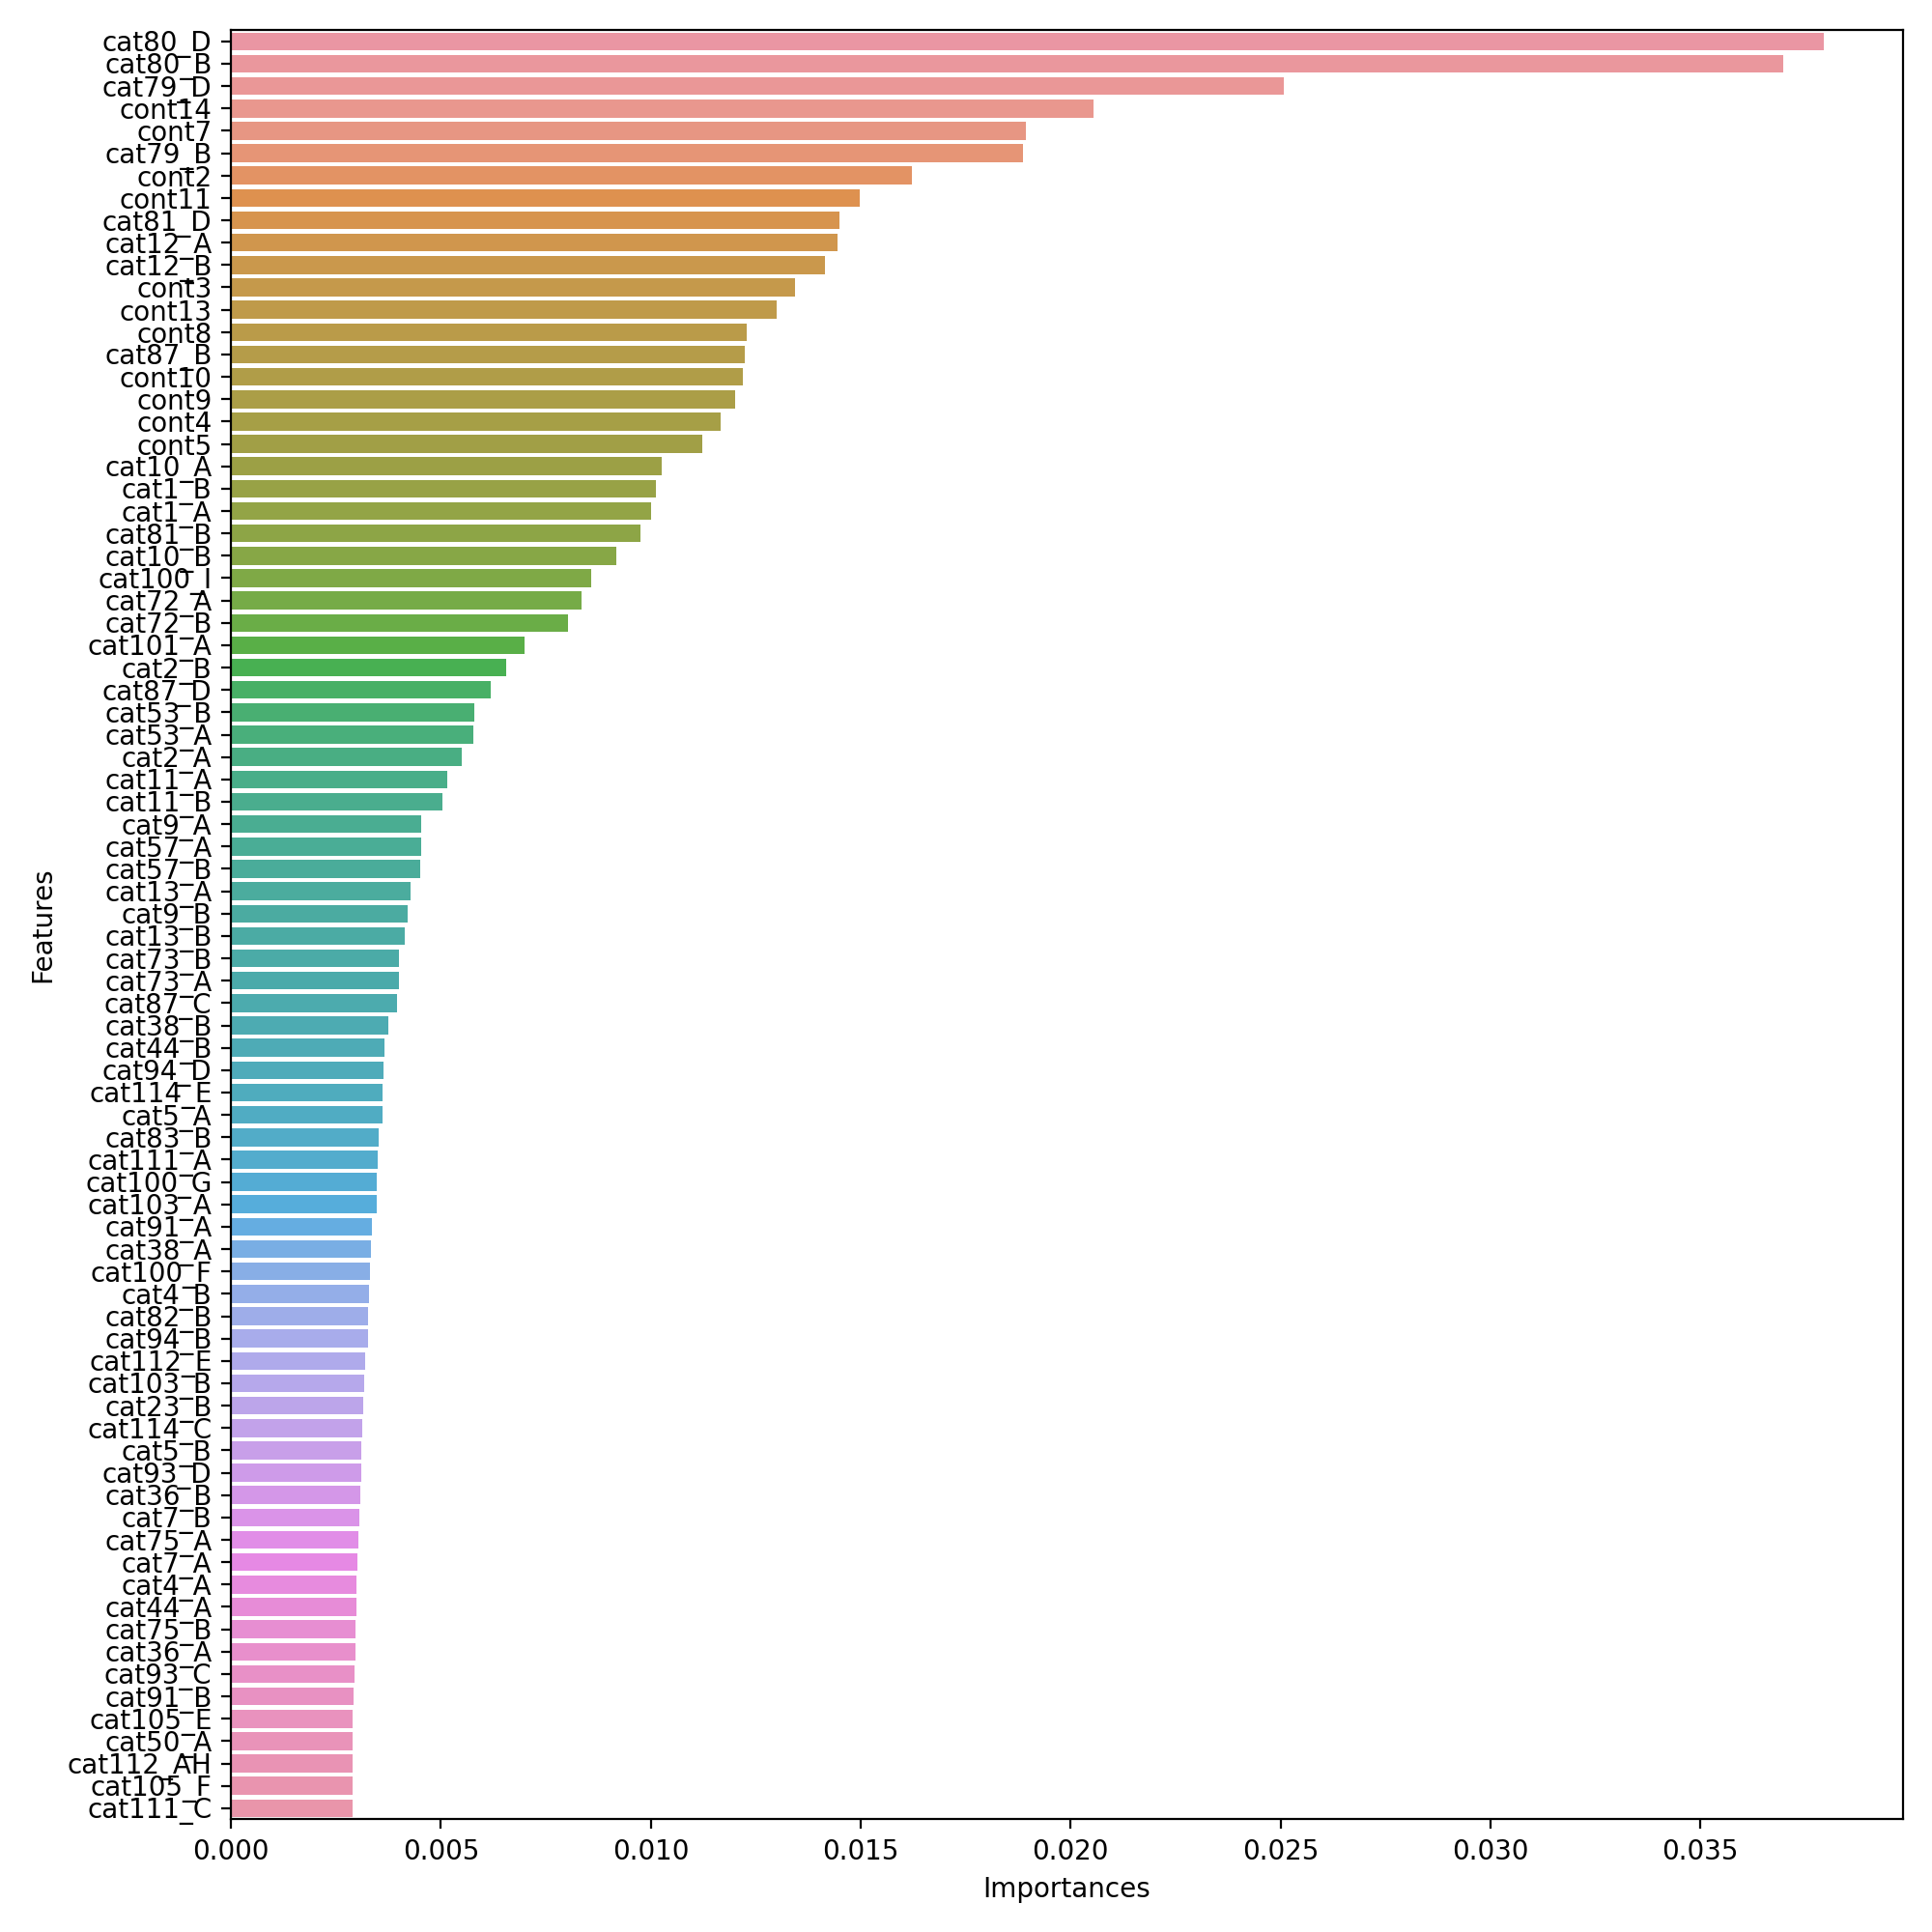

In [15]:
importances = feature_importances_rf(rf, Xtrain, num = 80)

In [31]:
#Selecting features using Random Forest
rf_sel_feat = importances[importances['Importances'] > 0.002]['Features']
rf_sel_feat

182     cat80_D
180     cat80_B
178     cat79_D
10       cont14
4         cont7
         ...   
185     cat81_C
420    cat107_F
187     cat82_A
364    cat104_E
63      cat27_A
Name: Features, Length: 126, dtype: object

In [32]:
X2[rf_sel_feat].head()

,cat80_D,cat80_B,cat79_D,cont14,cont7,cat79_B,cont2,cont11,cat81_D,cat12_A,...,cat37_A,cat101_C,cat100_L,cat3_B,cat83_D,cat81_C,cat107_F,cat82_A,cat104_E,cat27_A
179708,0,1,1,0.771928,0.591165,0,0.620805,0.757468,0,1,...,1,0,0,0,0,1,0,0,0,1
177008,1,0,0,0.604202,0.593072,1,0.827585,0.678924,1,1,...,1,0,0,0,0,0,0,0,0,0
9427,1,0,0,0.231667,0.303126,1,0.681761,0.291268,1,1,...,1,0,0,0,0,0,0,0,1,1
16385,0,1,0,0.725515,0.283691,1,0.737068,0.223038,1,1,...,1,0,0,0,0,0,0,0,0,1
91251,0,1,0,0.807027,0.214444,1,0.555782,0.160614,0,1,...,1,0,0,0,0,0,0,0,0,1


### Random Forest with selected features

In [33]:
#random forest parameter grid

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 30, num = 10)]
max_depth.append(None)
#min_samples_split = [2, 5, 10]
#min_samples_leaf = [1, 2, 4]

param_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth
               #'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf
               }
pprint(param_rf)

{'max_depth': [1, 4, 7, 10, 13, 17, 20, 23, 26, 30, None],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000]}


##### Make custom scorer to evaluate performance on original response scale 

In [34]:
from sklearn.metrics import make_scorer

def my_loss(ytrue, ypred):
    error = np.mean(abs(np.expm1(ytrue) - np.expm1(ypred)))
    return error

my_scorer = make_scorer(my_loss, greater_is_better=False)

##### Perform hyper-parameter tuning on the smaller training set with selected features using randomized search and 5-fold CV

In [35]:
start_time = time.time()
rf = RandomForestRegressor(random_state=SEED, n_jobs = -1)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_rf, n_iter = 10, cv = 5, verbose=1, scoring=my_scorer, n_jobs = -1)
# Fit the random search model
rf_random.fit(X2[rf_sel_feat], y2)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 37.5min finished


--- 2390.338497400284 seconds ---


In [36]:
print(rf_random.best_params_, rf_random.best_score_)
rf_random.best_estimator_ 

{'n_estimators': 911, 'max_features': 'auto', 'max_depth': 23} -1266.563131219746


RandomForestRegressor(max_depth=23, n_estimators=911, n_jobs=-1,
                      random_state=80)

In [37]:
rf2 = RandomForestRegressor(max_depth=23, n_estimators=911, n_jobs=-1,
                      random_state=80)

##### Perform 5-fold CV to evaluate model performance

In [38]:
from sklearn.model_selection import KFold, cross_val_score

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_results = cross_val_score(rf2, Xtrain[rf_sel_feat], ytrain, cv=cv, scoring=my_scorer)

In [39]:
print(cv_results)
print('MAE Mean {0:.2f}, Std {1:.2f}'.format(cv_results.mean(), cv_results.std()))

[-1214.66780359 -1207.44831124 -1199.08388621 -1216.15876815
 -1216.86993177]
MAE Mean -1210.85, Std 6.77


##### FIt the best model on the whole training data and make predictions on the held-out test data set

In [40]:
rf2.fit(Xtrain[rf_sel_feat],ytrain)
pred_rf = rf2.predict(Xtest[rf_sel_feat])

In [41]:
submit_rf = sample_submit
submit_rf['loss'] = pred_rf 
submit_rf.to_csv('submit_rf_sel.csv', index = False)

##### RF score on test set Private LB =  3024.03765 using top 126 important features 
##### This is same as the test set score using all 1187 features 3024.03

# LightGBM

In [10]:
#lgbm with default parameters 
lgb = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    objective='regression_l1',
    random_state=SEED,
    n_jobs=-1)


##### Let's perform variable selection using LightGBM model

In [23]:
def feature_importance(clf, X, num=100, figsize=(18, 6), importance_type = 'gain'):
    
    importances = pd.DataFrame({'Features': X.columns, 
                                'Importances': clf.booster_.feature_importance(importance_type=importance_type)})
    
    importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)

    fig = plt.figure(figsize=(10,10))
    sns.barplot(x='Features', y='Importances', data=importances[:num])
    plt.ylabel('Importance, type = ', importance_type)
    plt.xticks(rotation='vertical')
    plt.tight_layout()

    return importances


<IPython.core.display.Javascript object>


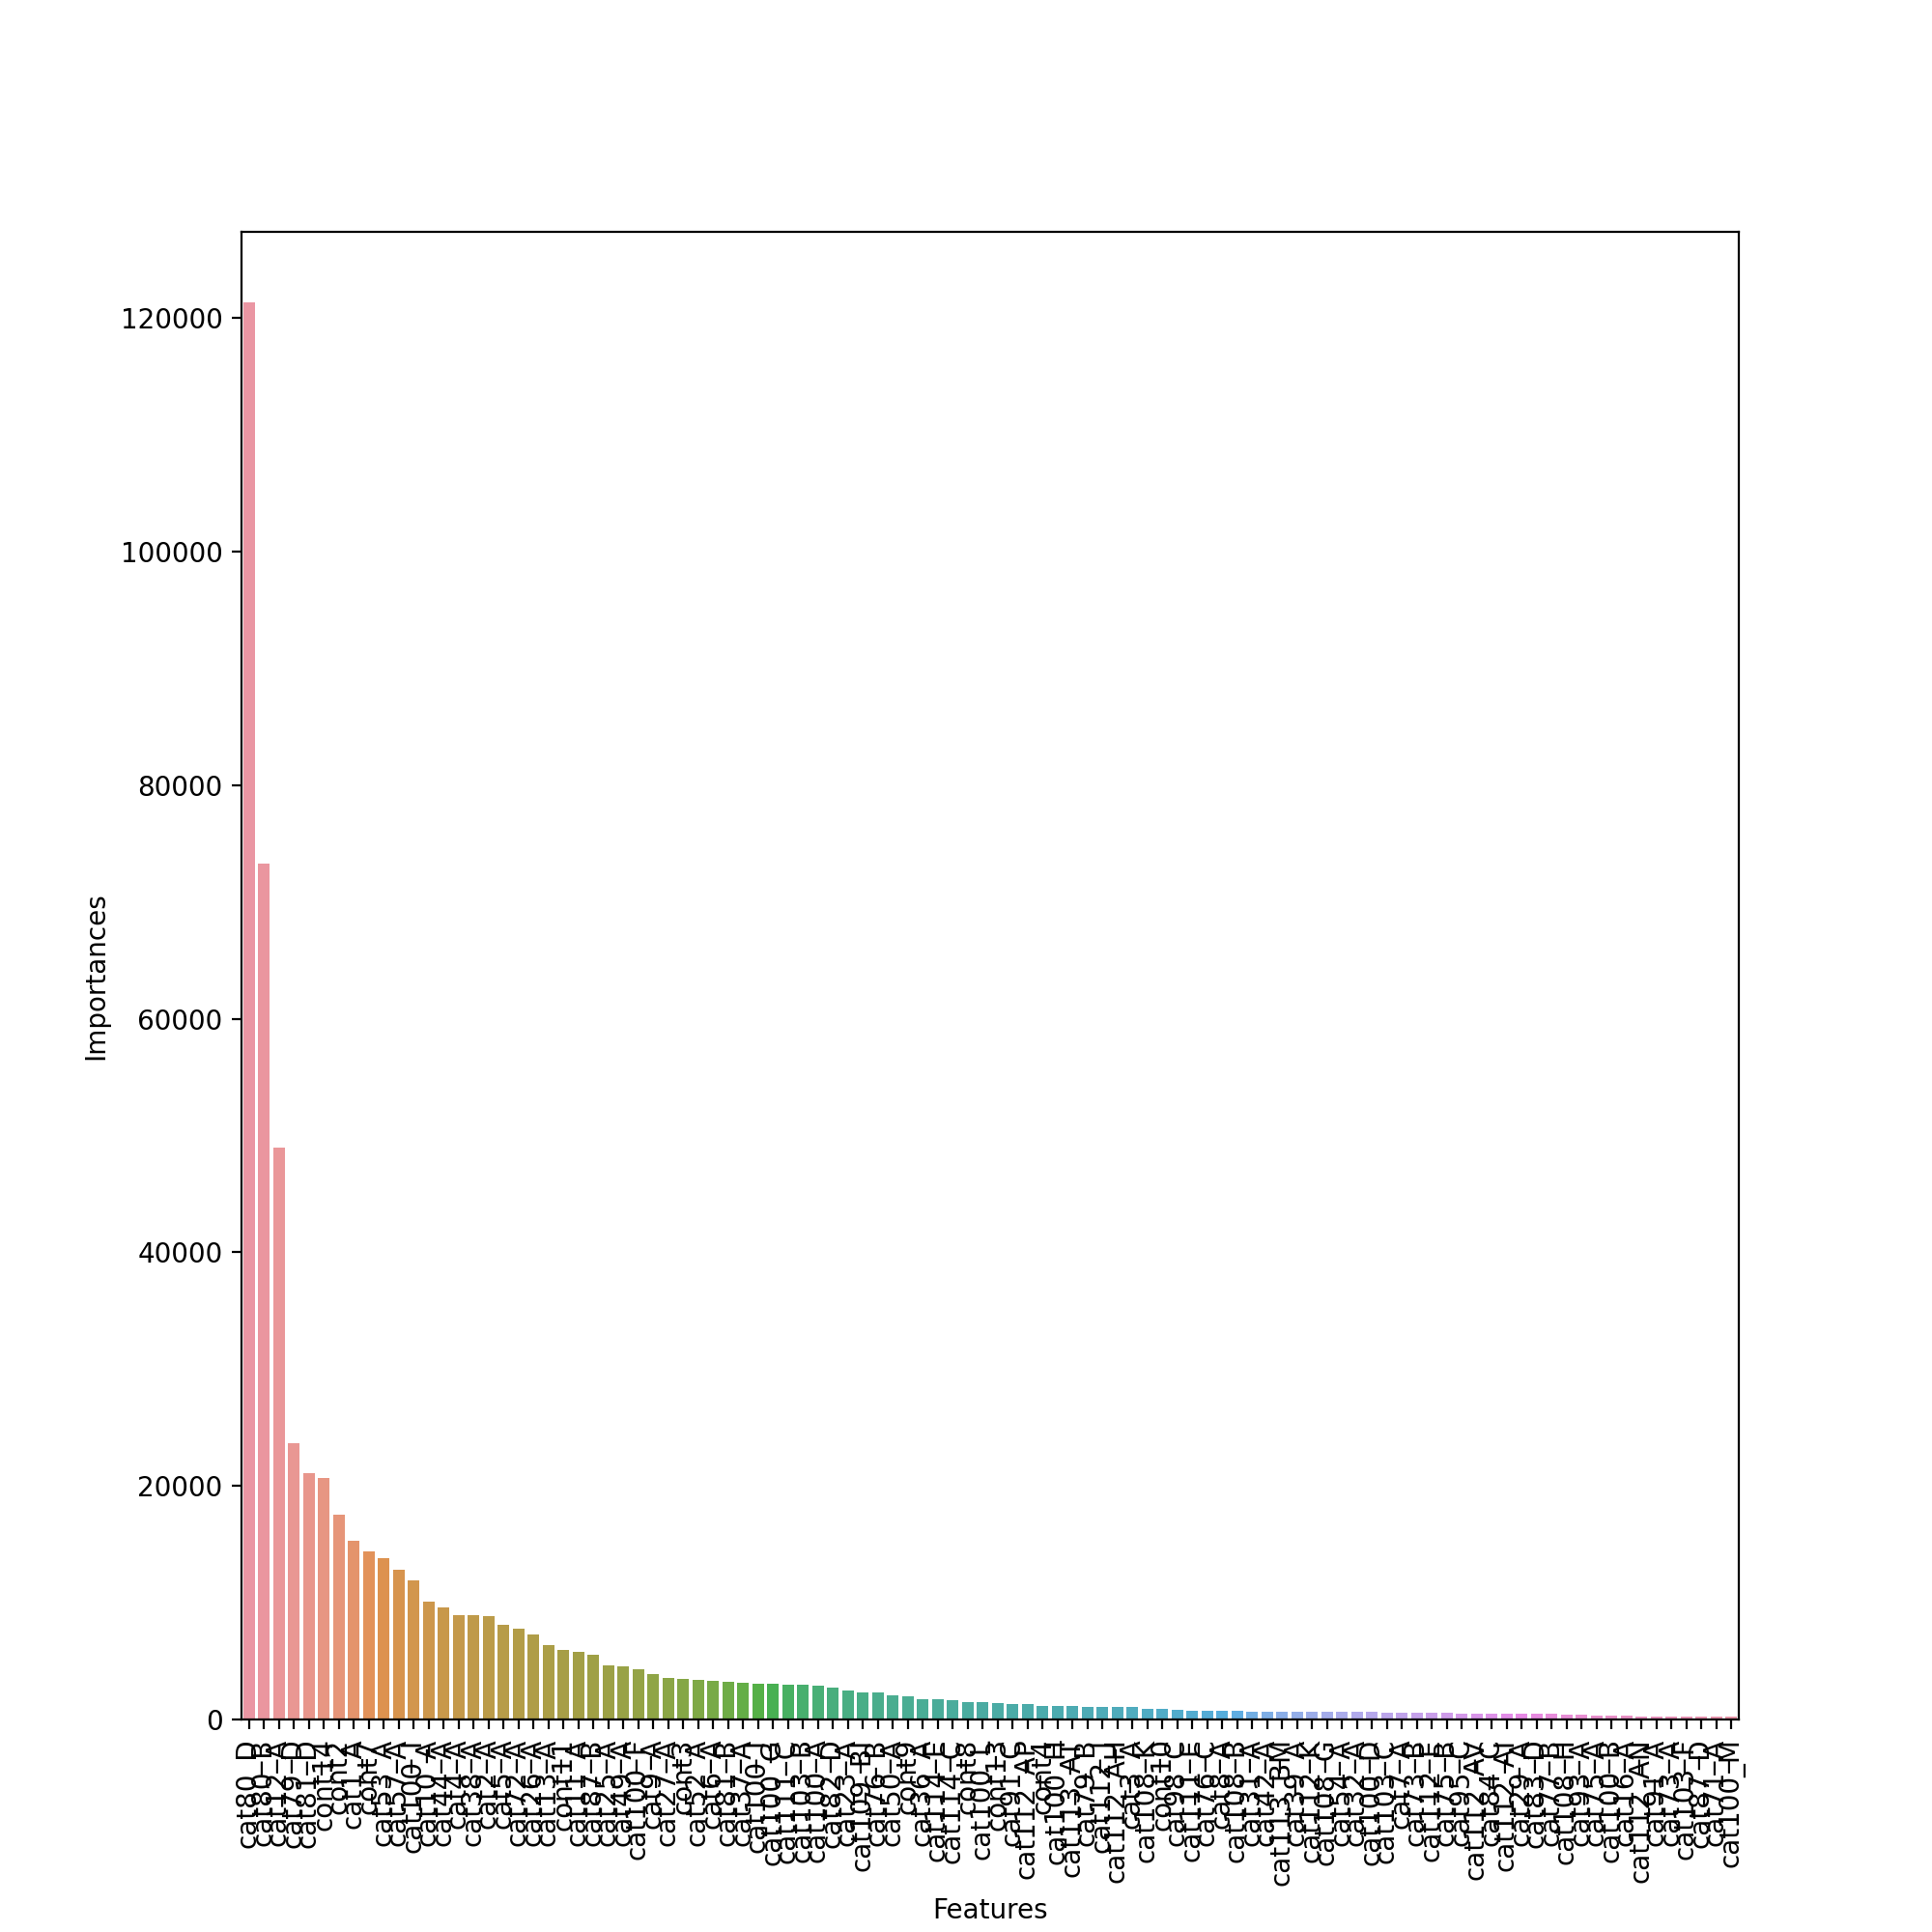

In [24]:
lgb.fit(Xtrain, ytrain)
lgbfi = feature_importances(lgb, Xtrain, num = 100)

In [30]:
lgbfi[lgbfi.Importances > 100]

,Features,Importances
182,cat80_D,121310.241848
180,cat80_B,73300.983922
33,cat12_A,48962.554785
178,cat79_D,23642.690380
186,cat81_D,21099.117697
...,...,...
321,cat101_D,119.043001
232,cat91_B,118.148800
324,cat101_G,114.753798
439,cat108_E,112.022000


In [34]:
sel_features = lgbfi[lgbfi.Importances > 100]['Features']
sel_features

182      cat80_D
180      cat80_B
33       cat12_A
178      cat79_D
186      cat81_D
         ...    
321     cat101_D
232      cat91_B
324     cat101_G
439     cat108_E
747    cat113_AN
Name: Features, Length: 129, dtype: object

### LGBM with selected features

In [37]:
param_lgb = {'n_estimators':randint(200,600),
              'colsample_bytree': uniform(0.6,0.3),
              'learning_rate': uniform(0.05, 0.095),
              #'max_depth': [int(x) for x in np.linspace(start = 2, stop = 12, num = 6)],
              'num_leaves':[15, 31, 63, 127, 255, 511, 1023, 2047, 4095]}
pprint(param_lgb)

lgbm = LGBMRegressor(objective='regression_l1', random_state=SEED, n_jobs = -1, verbosity=0)
grid_lg2 = RandomizedSearchCV(estimator=lgbm, param_distributions=param_lgb,n_iter=100, n_jobs=-1, cv=3, scoring='neg_mean_absolute_error',verbose=1)

def eval_mae(y_true, y_pred):
    mymae = np.mean(abs(np.expm1(y_true)-np.expm1(y_pred)))
    return 'mymae', mymae, False

grid_lg2.fit(X2[sel_features], y2, 
         eval_set = [(X1[sel_features],y1)],
         eval_metric = eval_mae,
         early_stopping_rounds = 15
         )

print(grid_lg2.best_params_, grid_lg2.best_score_)
#pprint(grid_lg.cv_results_['params'])
#pprint(grid_lg.cv_results_['mean_test_score'])
print(grid_lg2.best_estimator_)

{'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016D1A650820>,
 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016D1A6508E0>,
 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016D1A64B190>,
 'num_leaves': [15, 31, 63, 127, 255, 511, 1023, 2047, 4095]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 35.6min finished


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's l1: 0.639333	valid_0's mymae: 1765.17
Training until validation scores don't improve for 15 rounds
[2]	valid_0's l1: 0.619432	valid_0's mymae: 1721.29
[3]	valid_0's l1: 0.601072	valid_0's mymae: 1679.9
[4]	valid_0's l1: 0.585284	valid_0's mymae: 1643.34
[5]	valid_0's l1: 0.571572	valid_0's mymae: 1610.39
[6]	valid_0's l1: 0.559079	valid_0's mymae: 1579.5
[7]	valid_0's l1: 0.548576	valid_0's mymae: 1552.68
[8]	valid_0's l1: 0.538786	valid_0's mymae: 1527.54
[9]	valid_0's l1: 0.530212	valid_0's mymae: 1504.84
[10]	valid_0's l1: 0.522855	valid_0's mymae: 1484.58
[11]	valid_0's l1: 0.516243	valid_0's mymae: 1465.85
[12]	valid_0's l1: 0.509883	valid_0's mymae: 1448.45
[13]	valid_0's l1: 0.504395	valid_0's mymae: 1432.64
[14]	valid_0's l1: 0.499474	vali

[152]	valid_0's l1: 0.427939	valid_0's mymae: 1180.07
[153]	valid_0's l1: 0.427916	valid_0's mymae: 1179.98
[154]	valid_0's l1: 0.427836	valid_0's mymae: 1179.62
[155]	valid_0's l1: 0.427823	valid_0's mymae: 1179.6
[156]	valid_0's l1: 0.427806	valid_0's mymae: 1179.5
[157]	valid_0's l1: 0.42778	valid_0's mymae: 1179.37
[158]	valid_0's l1: 0.427759	valid_0's mymae: 1179.32
[159]	valid_0's l1: 0.427771	valid_0's mymae: 1179.36
[160]	valid_0's l1: 0.427761	valid_0's mymae: 1179.32
[161]	valid_0's l1: 0.427734	valid_0's mymae: 1179.26
[162]	valid_0's l1: 0.427726	valid_0's mymae: 1179.24
[163]	valid_0's l1: 0.427723	valid_0's mymae: 1179.22
[164]	valid_0's l1: 0.427737	valid_0's mymae: 1179.25
[165]	valid_0's l1: 0.427718	valid_0's mymae: 1179.22
[166]	valid_0's l1: 0.427714	valid_0's mymae: 1179.2
[167]	valid_0's l1: 0.427702	valid_0's mymae: 1179.11
[168]	valid_0's l1: 0.42766	valid_0's mymae: 1178.98
[169]	valid_0's l1: 0.427632	valid_0's mymae: 1178.88
[170]	valid_0's l1: 0.427628	vali

In [41]:
lgbm_sel = LGBMRegressor(colsample_bytree=0.6098557499942623,
              learning_rate=0.08416008406336566, n_estimators=258,
              objective='regression_l1', random_state=80, verbosity=0)

# cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
# cv_results = cross_val_score(lgbm_sel, Xtrain[sel_features], ytrain, cv=cv, scoring=my_scorer)

# print(cv_results)
# print('MAE Mean {0:.2f}, Std {1:.2f}'.format(cv_results.mean(), cv_results.std()))

In [38]:
lgbm_sel.fit(Xtrain[sel_features], ytrain)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


LGBMRegressor(colsample_bytree=0.6098557499942623,
              learning_rate=0.08416008406336566, n_estimators=258,
              objective='regression_l1', random_state=80, verbosity=0)

In [55]:
pred = lgbm_sel.predict(Xtest[sel_features], num_iteration = lgbm_sel.best_iteration_)

submit_lgbm = sample_submit
submit_lgbm['loss'] = np.expm1(pred)
submit_lgbm.to_csv('submit_lgbm_sel.csv', index = False)

##### LightGBM score on test set Private LB = 1139.70277 using top 129 important features
##### A difference of about 6 dollars as compared to LightGBM using all the 1187 features (score = 1133.78)